# Red Giant Mode fitting

Fitting $nstars$ RG stars chosen at random using Vrard model.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [6]:
#import output data
nstars = 50
IDs = []
stardat = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
for i in range(nstars):
    IDs.append(random.choice(stardat['ID']))

modes = {} # dictionary with frequencies and errors
for i in IDs:
    modes[str(i)] = pd.read_csv('RGdata/modes_'+str(i)+'.csv', delim_whitespace=False, header=0, usecols=[0,7])
    modes[str(i)] = modes[str(i)].sort_values(by=['f0'])
    modes[str(i)] = modes[str(i)].set_index(np.arange(0,len(modes[str(i)]),1))
    modes[str(i)]['dnu'] = modes[str(i)].f0.diff(2).shift(-1)/2
    dnu_avg = np.mean(modes[str(i)].dnu)
    n_min = int(modes[str(i)].f0.min() / dnu_avg)
    n_obs = np.arange(n_min, n_min+len(modes[str(i)].f0), 1)
    modes[str(i)]['n'] = n_obs
    
stardat= stardat.loc[stardat['ID'].isin(IDs)]

The model used will be that described in Vrard 2014:

$$\nu(n)=\left(n+\epsilon+\frac{\alpha}{2}\left(n_{max}-n\right)^2+\frac{\mathcal{A}\mathcal{G}}{2\pi}sin\left(\frac{2\pi\left(n-n_{max}\right)}{\mathcal{G}}+\phi\right)\right) \langle\Delta\nu\rangle$$

where is found from $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [7]:
def echelle(stardat, modes, ID, model=False, stanfit=[], stan_dnu=0):
    numax_obs = float(stardat.loc[stardat['ID'] == ID].Numax)
    numax_obs_err = float(stardat.loc[stardat['ID'] == ID].Numax_err)
    #dnu_obs = float(stardat.loc[stardat.ID == IDs[i]].Dnu_median_all)
    #dnu_obs = np.mean(np.diff(modes[str(IDs[i])].f0)) 
    dnu_obs = np.mean(modes[str(ID)].f0.diff(2).shift(-1)/2)
    # Create dataframes for frequencies and calculate orders n
    l0modes = pd.DataFrame([modes[str(ID)].f0, modes[str(ID)].f0_err])
    l0modes = l0modes.T
    l0modes = l0modes.sort_values('f0', ascending=True)
    n_min = int(l0modes.f0.min() / dnu_obs)
    n_obs = np.arange(n_min, n_min+len(l0modes.f0), 1)
    l0modes['n'] = n_obs
    l0modes = l0modes.set_index(np.arange(0, len(l0modes.f0), 1))
    plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = str(ID))
    
    if model:
        label = 'Stan Fit '+str(ID)
        plt.plot(stanfit % stan_dnu, stanfit, label = label)
        
    plt.xlabel(r'Frequency modulo ($\mu Hz$)')
    plt.ylabel(r'Frequency ($\mu Hz$)')
    plt.legend()

In [8]:
def model(n, dnu, nmax, epsilon, alpha, A, G, phi):
    freqs = (n + epsilon + alpha/2 * (nmax - n)**2 + A*G/(2*np.pi) * np.sin((2*np.pi*(n-nmax))/G + phi))*dnu #* np.exp(-n/tau);
    return freqs

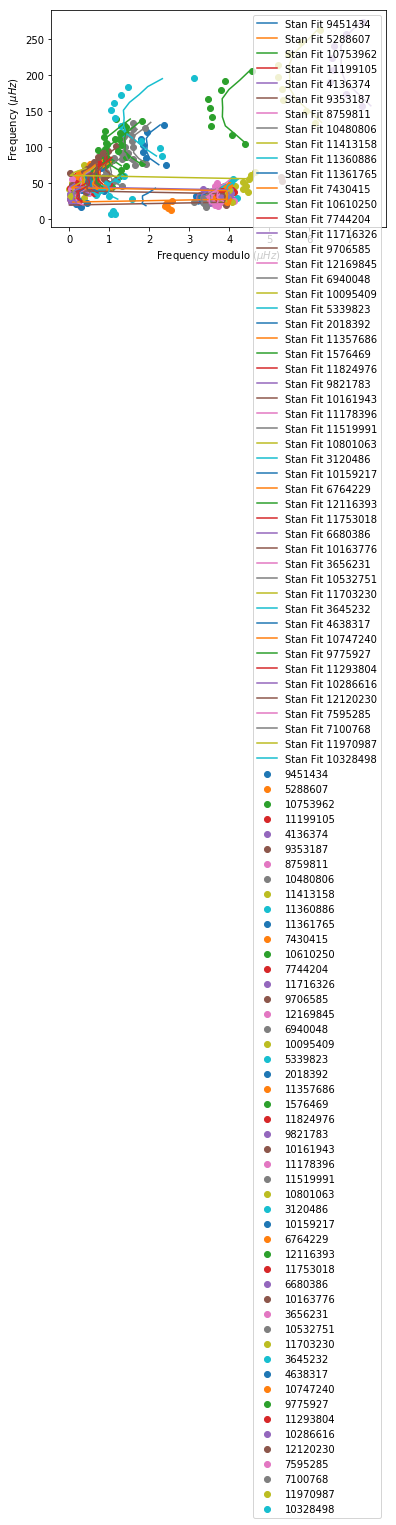

In [9]:
for i in IDs:
    #values from Vrard
    dnu_avg = np.mean(modes[str(i)].dnu)
    n = modes[str(i)].n
    #epsilon = 0.601 + 0.632*np.log(dnu_avg)
    epsilon = np.median((modes[str(i)].f0 % dnu_avg) / dnu_avg)
    numax_obs = float(stardat.loc[stardat['ID'] == i].Numax)
    nmax = numax_obs/dnu_avg - epsilon
    alpha = 0.015*dnu_avg**(-0.32)
    A = 0.06*dnu_avg**(-0.88) 
    G = 3.08
    #tau = 8
    phi = 1.71
    f = model(n, dnu_avg, nmax, epsilon, alpha, A, G, phi)
    echelle(stardat, modes, i, True, f, dnu_avg)
    

In [10]:
'''plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') 
plt.plot(f % dnu_obs, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)
plt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')
plt.legend()'''

"plt.scatter(l0modes.f0 % dnu_obs, l0modes.f0, label = 'Data') \nplt.plot(f % dnu_obs, f, label = 'Model')\nplt.xlabel(r'Frequency modulo ($\\mu Hz$)')\nplt.ylabel(r'Frequency ($\\mu Hz$)')\n#mod_err = (l0modes.f0 % dnu_obs)*np.sqrt((dnu_obs_err/dnu_obs)**2 + (l0modes.f0_err/l0modes.f0)**2)\nplt.errorbar(l0modes.f0 % dnu_obs, l0modes.f0, yerr = l0modes.f0_err, xerr = mod_err, ecolor = 'r', ls='none', label = 'Error')\nplt.legend()"

In [11]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
}
parameters {
    real dnu;
    real nmax;
    real epsilon;
    real alpha;
    real<lower = 0> A;
    real<lower = 0> G;
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi;
    //real<lower = 0> tau;
    real epsA;
    real epsB;
    real alA;
    real alB;
    real AA;
    real AB;
    
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon + (alpha/2) * (nmax - n[i])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[i]-nmax))/G + phi))*dnu;
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(epsA + epsB*log(dnu), 0.5);
    epsilon ~ uniform(-1.0, 2.0);
    nmax ~ normal(10, 4);
    alpha ~ lognormal(log(alA*dnu^(-alB)), 0.3);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    A ~ lognormal(log(AA*dnu^(-AB)), 0.4);
    //A ~ lognormal(log(0.06*dnu^(-0.88)), 0.4);
    G ~ normal(3.08, 0.65);
    // tau ~ normal(50, 10);
    epsA ~ normal(0.601, 0.080);
    epsB ~ normal(0.632, 0.080);
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    AA ~ normal(0.06, 0.01);
    AB ~ normal(0.88, 0.05);
}
generated quantities{
    real fm[N];
    for (j in 1:N){
        fm[j] = (n[j] + epsilon + (alpha/2) * (nmax - n[j])^2 + 
            A*G/(2*pi()) * sin((2*pi()*(n[j]-nmax))/G + phi))*dnu;
        }
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_0dda3e4b285fc6a0f5224af403aead82 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpdny3r5i1/stanfit4anon_model_0dda3e4b285fc6a0f5224af403aead82_9130089058026774815.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [12]:
fits = {}
for i in IDs:
    dat_star = stardat.loc[stardat['ID'] == i]
    df_star = modes[str(i)]
    df_star = df_star.sort_values(by=['f0'])
    dnu_obs = np.mean(df_star.dnu)
    numax_obs = float(dat_star.loc[dat_star['ID'] == i].Numax)
    df_star = df_star.set_index(np.arange(0, len(df_star.f0), 1))
    nmax_guess = np.mean(df_star.n)
    epsilon_obs = np.median((df_star.f0 % dnu_obs) / dnu_obs)
    #epsilon_obs = 0.601 + 0.632*np.log(dnu_obs)
    alpha_obs = 0.015*dnu_obs**(-0.32)
    A_obs = 0.06*dnu_obs**(-0.88)
    
    data = {'N': len(df_star.f0), 'n': df_star.n.values, 'freq': df_star.f0.values,
            'freq_err': df_star.f0_err.values, 'dnu_guess': dnu_obs}
    start = {'dnu': dnu_obs, 'epsilon': epsilon_obs, 
             'nmax': numax_obs/dnu_obs - epsilon_obs, 'alpha': alpha_obs, 'A': A_obs,
             'G': 3, 'phi': 1.6}
    nchains=4
    fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])
    fits[str(i)] = fit
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'alpha': fit['alpha'], 'A': fit['A'], 'G': fit['G'], 'phi': fit['phi'], 
                           'epsA': fit['epsA'], 'epsB': fit['epsB'], 'alA': fit['alA'], 'alB': fit['alB'],
                           'AA': fit['AA'], 'AB': fit['AB']})
    #output.to_csv('samples_' + str(i) + '.csv')

In [13]:
for i in IDs:
    print('ID = ' + str(i))
    print(fits[str(i)])

ID = 9451434
Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.61  4.6e-5 3.6e-3    3.6   3.61   3.61   3.61   3.62   6092    1.0
nmax      7.04  2.0e-3   0.13    6.8   6.96   7.04   7.12   7.32   4251    1.0
epsilon   0.88  1.3e-4 9.2e-3   0.86   0.87   0.88   0.89    0.9   5246    1.0
alpha     0.02  6.5e-5 4.7e-3   0.01   0.02   0.02   0.03   0.03   5196    1.0
A         0.04  1.3e-4   0.01   0.02   0.03   0.04   0.05   0.07   7392    1.0
G         2.27  3.8e-3   0.26   1.83   2.09   2.25   2.42   2.85   4710    1.0
phi       1.46  9.1e-3   0.59   0.37   1.05   1.41   1.83    2.7   4287    1.0
epsA      0.59  7.4e-4   0.08   0.44   0.54   0.59   0.64   0.74  11061    1.0
epsB      0.61  7.2e-4   0.08   0.46   0.56   0.61   0.67   0.77  11792    1.0
alA    

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       6.71  9.2e-5 6.7e-3    6.7   6.71   6.71   6.72   6.73   5331    1.0
nmax     11.34  2.2e-3   0.16  11.05  11.23  11.33  11.44  11.68   5102    1.0
epsilon   0.11  1.6e-4   0.01   0.09    0.1   0.11   0.12   0.13   5211    1.0
alpha  10.0e-3  9.3e-6 8.9e-4 8.3e-3 9.4e-310.0e-3   0.01   0.01   9069    1.0
A         0.02  5.8e-5 4.7e-3   0.01   0.02   0.02   0.02   0.03   6535    1.0
G         3.54  3.7e-3   0.29   3.08   3.33   3.51   3.71   4.23   6205    1.0
phi       0.87  5.1e-3   0.35    0.2   0.63   0.86    1.1    1.6   4908    1.0
epsA      0.56  7.7e-4   0.08   0.41   0.51   0.56   0.62   0.72  10635    1.0
epsB      0.56  7.5e-4   0.08    0.4   0.51   0.56   0.61   0.71  10599    1.0
alA       0.02  3.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.18  6.2e-5 4.2e-3   4.17   4.18   4.18   4.18   4.19   4713    1.0
nmax     10.64  6.9e-3   0.35    9.8  10.46  10.69  10.88  11.19   2658    1.0
epsilon   0.12  1.8e-4   0.01   0.09   0.11   0.12   0.12   0.14   4076    1.0
alpha   6.5e-3  2.6e-5 1.7e-3 3.4e-3 5.3e-3 6.4e-3 7.6e-3   0.01   4656    1.0
A         0.03  7.1e-5 6.1e-3   0.02   0.03   0.03   0.03   0.04   7334    1.0
G         4.23  4.1e-3   0.32   3.69   4.01   4.21   4.43   4.92   6216    1.0
phi     9.1e-3    0.01   0.62  -1.42   -0.3   0.09   0.43   0.95   2768    1.0
epsA      0.57  8.2e-4   0.08   0.41   0.51   0.57   0.62   0.72   9359    1.0
epsB      0.59  8.0e-4   0.08   0.43   0.53   0.58   0.64   0.74   9872    1.0
alA       0.01  4.8e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       5.14  8.1e-5 5.0e-3   5.13   5.14   5.14   5.14   5.15   3894    1.0
nmax     10.53  3.4e-3   0.22  10.11  10.38  10.53  10.67  10.97   3920    1.0
epsilon   0.07  1.7e-4   0.01   0.04   0.06   0.07   0.07   0.09   3777    1.0
alpha   6.8e-3  8.6e-6 9.7e-4 4.9e-3 6.1e-3 6.8e-3 7.5e-3 8.7e-3  12768    1.0
A         0.06  6.2e-5 5.8e-3   0.04   0.05   0.06   0.06   0.07   8801    1.0
G         3.04  7.3e-4   0.07    2.9   2.99   3.03   3.08   3.18   8955    1.0
phi       1.47  7.3e-3   0.46    0.6   1.17   1.46   1.77   2.41   3945    1.0
epsA      0.56  7.5e-4   0.08   0.41   0.51   0.56   0.62   0.72  11188    1.0
epsB      0.57  7.4e-4   0.08   0.42   0.52   0.57   0.62   0.72  10812    1.0
alA       0.01  3.6e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       4.18  6.2e-5 4.2e-3   4.17   4.18   4.18   4.18   4.19   4604    1.0
nmax      10.1  1.7e-3   0.11   9.88  10.03   10.1  10.18  10.33   4495    1.0
epsilon-7.4e-3  1.6e-4   0.01  -0.03  -0.01-7.4e-3-1.8e-4   0.01   4270    1.0
alpha     0.02  1.6e-5 1.6e-3   0.01   0.01   0.02   0.02   0.02  10212    1.0
A         0.03  7.8e-5 6.0e-3   0.01   0.02   0.03   0.03   0.04   6090    1.0
G         3.23  3.4e-3   0.26   2.79   3.05    3.2   3.37   3.82   5945    1.0
phi       2.61  4.0e-3   0.27   2.09   2.43   2.61   2.79   3.13   4551    1.0
epsA      0.57  8.2e-4   0.08   0.41   0.51   0.56   0.62   0.72   9094    1.0
epsB      0.58  7.8e-4   0.08   0.43   0.53   0.58   0.63   0.73   9925    1.0
alA       0.02  3.8e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       7.39  1.1e-4 7.4e-3   7.38   7.39   7.39    7.4   7.41   4731    1.0
nmax     12.03  1.8e-3   0.12  11.79  11.94  12.02  12.11  12.27   4779    1.0
epsilon   0.11  1.8e-4   0.01   0.08    0.1    0.1   0.11   0.13   4738    1.0
alpha     0.01  6.5e-6 6.4e-4 9.0e-3 9.8e-3   0.01   0.01   0.01   9758    1.0
A         0.02  6.4e-5 5.4e-3   0.01   0.02   0.02   0.03   0.04   7078    1.0
G         2.67  1.4e-3   0.11   2.49   2.59   2.65   2.73   2.92   6212    1.0
phi       1.91  5.0e-3   0.35    1.2   1.68   1.91   2.14   2.58   4791    1.0
epsA      0.56  7.2e-4   0.08    0.4   0.51   0.56   0.61   0.72  12221    1.0
epsB      0.55  6.8e-4   0.08    0.4    0.5   0.55    0.6    0.7  12424    1.0
alA       0.02  3.3e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.92  4.7e-5 3.9e-3   3.91   3.92   3.92   3.92   3.93   6904    1.0
nmax      5.92    0.01   0.53   4.72   5.65   5.96   6.26   6.81   2333    1.0
epsilon   0.92  1.1e-4 8.2e-3   0.91   0.92   0.92   0.93   0.94   5866    1.0
alpha   8.0e-3  4.9e-5 3.4e-3 2.3e-3 5.6e-3 7.7e-3   0.01   0.02   4657    1.0
A         0.04  1.4e-4   0.01   0.02   0.03   0.04   0.05   0.07   7920    1.0
G         2.67  4.2e-3   0.35   2.01   2.44   2.64   2.87   3.46   7257    1.0
phi       4.14    0.02   1.18   1.48   3.49   4.21   4.94    6.1   2328    1.0
epsA      0.59  7.2e-4   0.08   0.43   0.53   0.59   0.64   0.74  11967    1.0
epsB      0.61  7.0e-4   0.08   0.46   0.56   0.61   0.67   0.77  12672    1.0
alA       0.01  6.5e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       5.45  7.7e-5 5.5e-3   5.44   5.44   5.45   5.45   5.46   5162    1.0
nmax      9.99  1.5e-3    0.1    9.8   9.92   9.98  10.05  10.19   4613    1.0
epsilon   0.08  1.4e-4   0.01   0.06   0.07   0.08   0.08    0.1   5271    1.0
alpha     0.02  1.7e-5 1.4e-3   0.01   0.02   0.02   0.02   0.02   6776    1.0
A         0.02  5.8e-5 5.0e-3   0.01   0.02   0.02   0.02   0.03   7423    1.0
G          3.0  4.0e-3   0.29   2.55    2.8   2.96   3.15   3.72   5345    1.0
phi        1.9  5.3e-3   0.38   1.17   1.65    1.9   2.15   2.65   5031    1.0
epsA      0.56  7.5e-4   0.08   0.41   0.51   0.56   0.62   0.72  10855    1.0
epsB      0.57  7.5e-4   0.08   0.42   0.52   0.57   0.62   0.72  10436    1.0
alA       0.02  3.4e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.87  4.5e-5 3.9e-3   3.86   3.86   3.87   3.87   3.87   7485    1.0
nmax      7.56  8.0e-3   0.38    7.0   7.32    7.5   7.73   8.54   2291    1.0
epsilon   0.84  1.2e-4 9.7e-3   0.82   0.84   0.84   0.85   0.86   6921    1.0
alpha     0.01  5.9e-5 4.2e-3 5.2e-3   0.01   0.01   0.02   0.02   5077    1.0
A         0.03 10.0e-5 7.8e-3   0.02   0.02   0.03   0.03   0.05   6117    1.0
G         4.17    0.04   0.53   2.98    3.9   4.19   4.48   5.08    182   1.02
phi       0.04    0.04   0.67  -1.15  -0.37 2.8e-3   0.37    1.7    294   1.01
epsA      0.59  7.2e-4   0.08   0.43   0.53   0.59   0.64   0.74  12446    1.0
epsB      0.61  6.8e-4   0.08   0.46   0.56   0.61   0.66   0.76  12846    1.0
alA       0.02  5.4e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu        4.1  5.3e-5 4.1e-3   4.09   4.09    4.1    4.1    4.1   5967    1.0
nmax      6.93  2.6e-3   0.17   6.57   6.83   6.94   7.04   7.27   4444    1.0
epsilon   0.94  1.2e-4 8.7e-3   0.92   0.94   0.94   0.95   0.96   5264    1.0
alpha     0.02  6.3e-5 4.4e-3 9.3e-3   0.01   0.02   0.02   0.03   5048    1.0
A         0.03  1.1e-4 9.2e-3   0.02   0.03   0.03   0.04   0.05   7116    1.0
G         2.71  5.7e-3   0.35   2.19   2.48   2.66   2.88   3.54   3771    1.0
phi       0.57  8.5e-3   0.51  -0.48   0.27   0.59   0.89   1.49   3589    1.0
epsA      0.59  7.6e-4   0.08   0.43   0.53   0.59   0.64   0.74  10953    1.0
epsB      0.61  7.4e-4   0.08   0.46   0.56   0.61   0.66   0.77  11371    1.0
alA       0.02  4.3e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       8.46  1.3e-4 8.3e-3   8.44   8.45   8.46   8.46   8.47   4391    1.0
nmax     12.48  2.1e-3   0.13  12.23  12.39  12.48  12.57  12.75   3953    1.0
epsilon   0.14  1.9e-4   0.01   0.12   0.14   0.14   0.15   0.17   4223    1.0
alpha   9.7e-3  8.2e-6 7.9e-4 8.3e-3 9.2e-3 9.7e-3   0.01   0.01   9230    1.0
A         0.02  2.7e-5 2.7e-3   0.01   0.02   0.02   0.02   0.02  10113    1.0
G         3.67  2.9e-3   0.26   3.23   3.49   3.64   3.82   4.23   7756    1.0
phi        1.6  4.9e-3   0.33   0.98   1.36   1.59   1.82   2.28   4630    1.0
epsA      0.56  7.0e-4   0.08   0.41   0.51   0.56   0.61   0.72  12807    1.0
epsB      0.55  6.8e-4   0.08   0.39   0.49   0.55    0.6   0.69  12795    1.0
alA       0.02  3.4e

Inference for Stan model: anon_model_0dda3e4b285fc6a0f5224af403aead82.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       3.77  4.6e-5 3.8e-3   3.77   3.77   3.77   3.78   3.78   6656    1.0
nmax      7.03  1.3e-3   0.09   6.85   6.96   7.02   7.09   7.22   5189    1.0
epsilon    0.9  1.2e-4 8.4e-3   0.89    0.9    0.9   0.91   0.92   5239    1.0
alpha     0.02  1.7e-4 1.7e-3   0.02   0.02   0.02   0.02   0.02     93   1.02
A         0.05  7.9e-3   0.01   0.03   0.04   0.05   0.06   0.08      3   1.84
G         2.41     0.3   0.45    1.6    2.0   2.58   2.72   2.99      2   3.11
phi      -0.78    0.94   1.35  -3.49  -1.34  -0.16    0.1   0.55      2   4.58
epsA      0.59  7.2e-4   0.08   0.44   0.53   0.59   0.64   0.75  12032    1.0
epsB      0.62  6.3e-4   0.08   0.46   0.56   0.62   0.67   0.77  15270    1.0
alA       0.02  3.0e

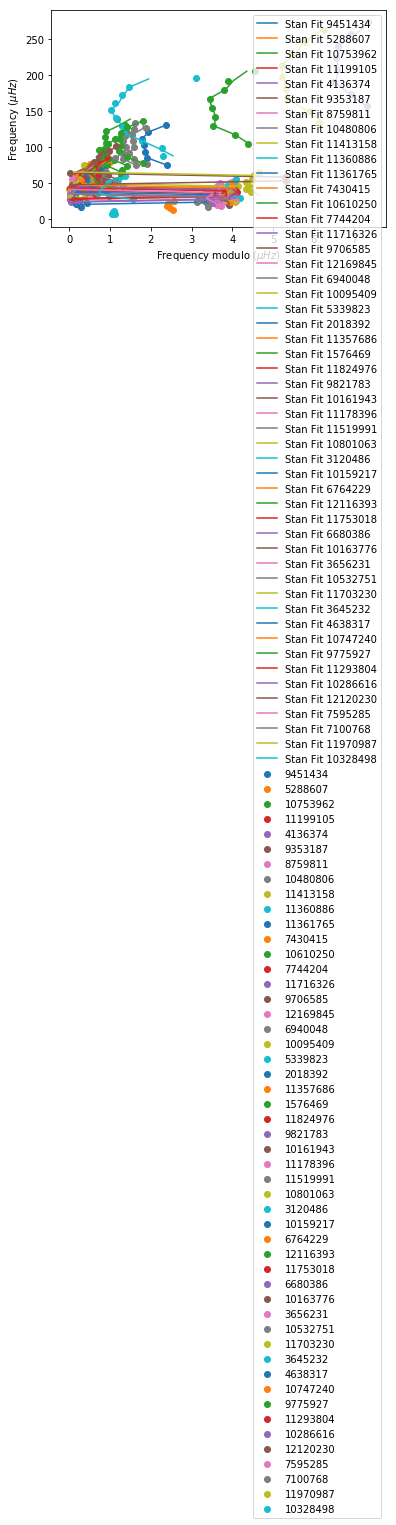

In [14]:
for i in IDs:
    stanfit = model(modes[str(i)].n, fits[str(i)]['dnu'].mean(), fits[str(i)]['nmax'].mean(), fits[str(i)]['epsilon'].mean(), fits[str(i)]['alpha'].mean(), fits[str(i)]['A'].mean(), fits[str(i)]['G'].mean(), fits[str(i)]['phi'].mean())
    stan_dnu = fits[str(i)]['dnu'].mean()
    echelle(stardat, modes, i, True, stanfit, stan_dnu)

Text(0.5, 0.98, 'Parameters plotted against $\\langle \\Delta \\nu \\rangle$')

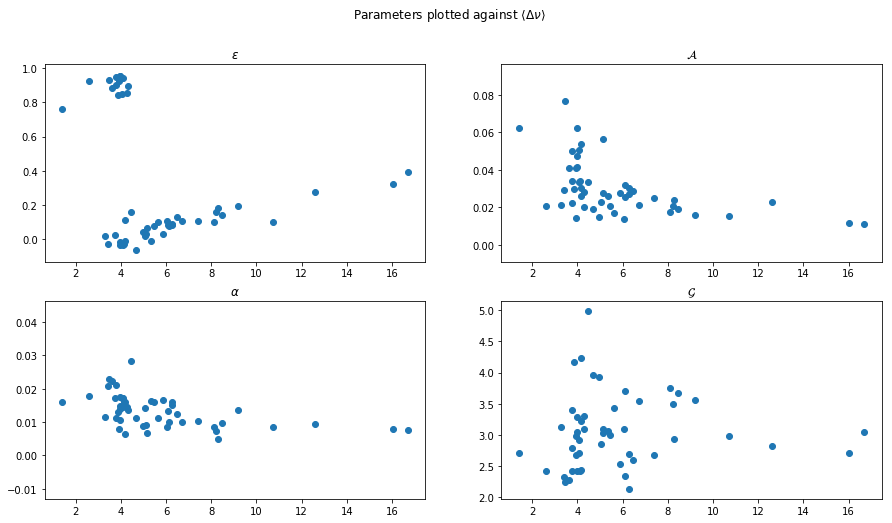

In [21]:
dnus = []
epsilons = []
alphas = []
As = []
Gs = []
for i in IDs:
    dnus.append(fits[str(i)]['dnu'].mean())
    epsilons.append(fits[str(i)]['epsilon'].mean())
    alphas.append(fits[str(i)]['alpha'].mean())
    As.append(fits[str(i)]['A'].mean())
    Gs.append(fits[str(i)]['G'].mean())
    
fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharey=False)
axs[0,0].scatter(dnus, epsilons)
axs[0,0].set_title(r'$\epsilon$')
axs[1,0].scatter(dnus, alphas)
axs[1,0].set_title(r'$\alpha$')
axs[0,1].scatter(dnus, As)
axs[0,1].set_title(r'$\mathcal{A}$')
axs[1,1].scatter(dnus, Gs)
axs[1,1].set_title(r'$\mathcal{G}$')
fig.suptitle(r'Parameters plotted against $\langle \Delta \nu \rangle$')

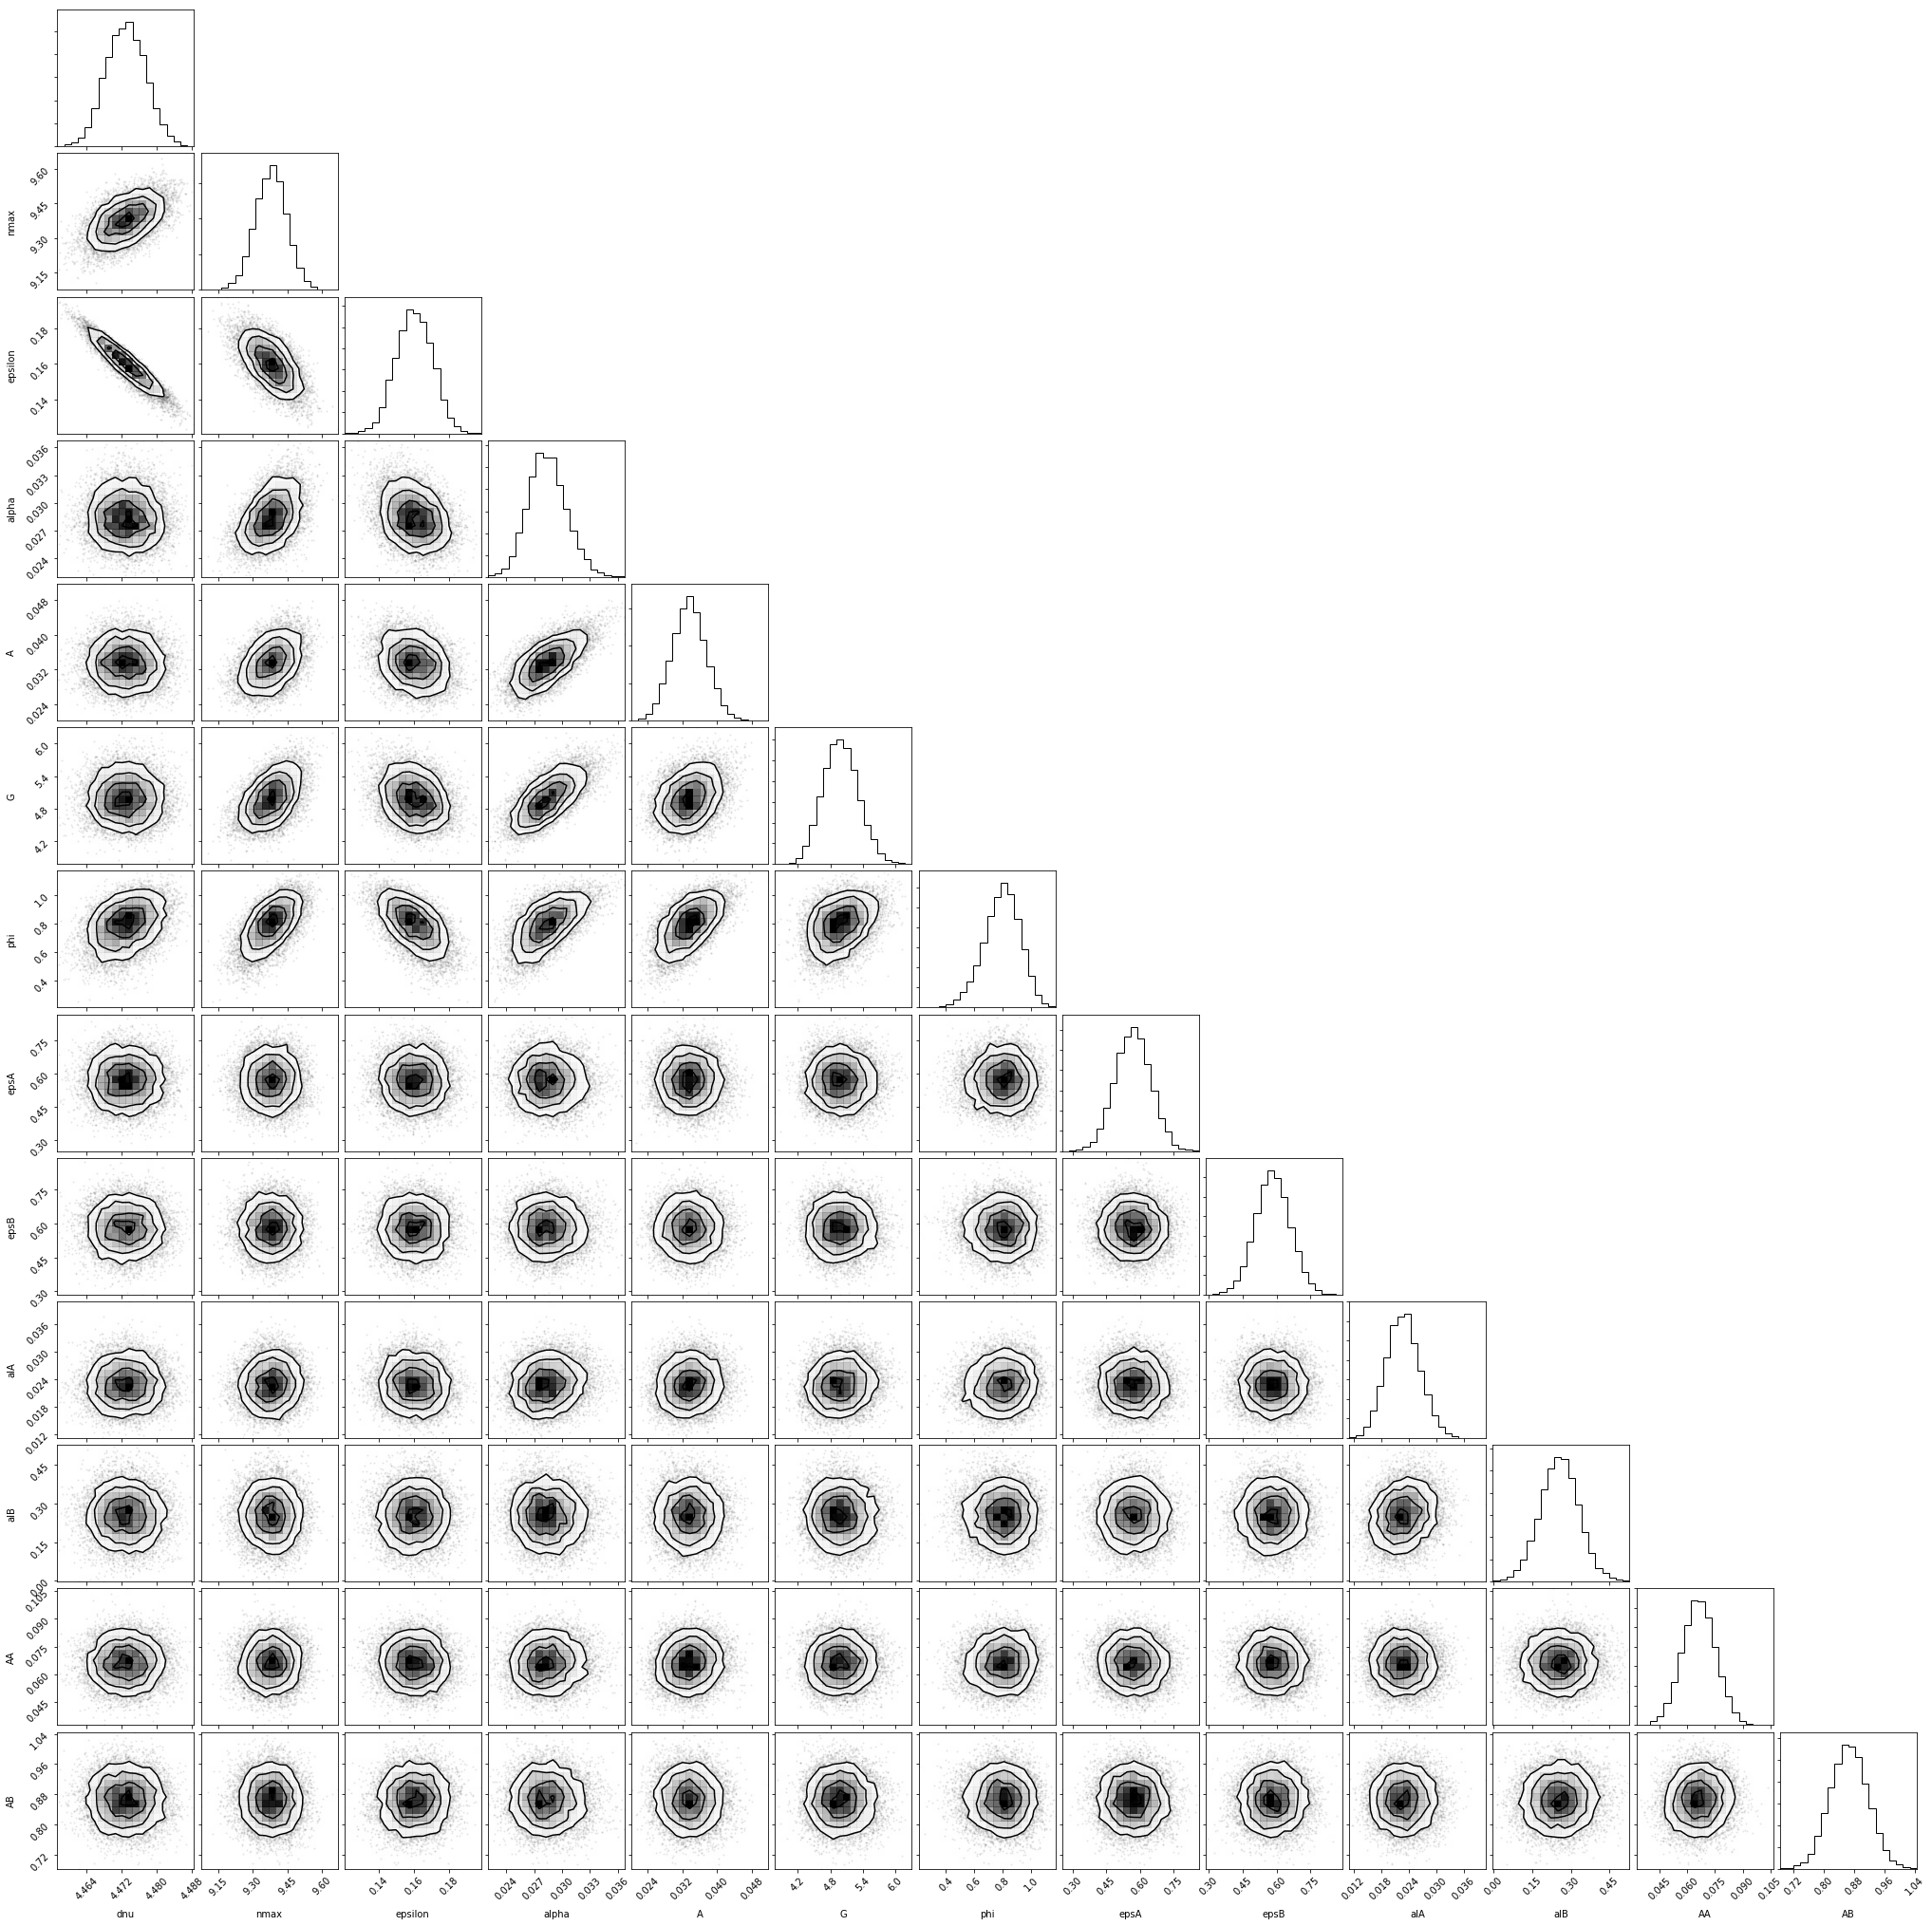

In [22]:
import corner
data = np.vstack([fit['dnu'], fit['nmax'], fit['epsilon'], fit['alpha'], fit['A'], fit['G'], fit['phi'], 
                fit['epsA'], fit['epsB'], fit['alA'], fit['alB'], fit['AA'], fit['AB']]).T
corner.corner(data, labels=['dnu', 'nmax', 'epsilon', 'alpha', 'A', 'G', 'phi', 'epsA', 'epsB', 'alA', 'alB', 'AA', 'AB'])
plt.show()